# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [2]:
!pip install -q optuna

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import optuna

from sklearn.preprocessing import OneHotEncoder,StandardScaler,FunctionTransformer,OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor, BayesianRidge, LassoLars
from sklearn.linear_model import ARDRegression, PassiveAggressiveRegressor, TheilSenRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline,FeatureUnion

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

import random
import time
import warnings

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
def data_analis (df):
    i=df.info()
    h=df.head()
    ds=df.describe()
    dp=df.duplicated().sum()
    return print(i),print(h), print(ds), print('дубликаты:',dp)

In [5]:
data_analis(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

(None, None, None, None)

### переработка данных

In [6]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
data = data[data['Price'] != 0]
data = data[(data['RegistrationYear'] > 1900) & (data['RegistrationYear'] <= 2020)]
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [7]:
data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']] = \
data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']].fillna('unk')

In [8]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,unk,1993,manual,0,golf,150000,0,petrol,volkswagen,unk
1,18300,coupe,2011,manual,190,unk,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unk
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


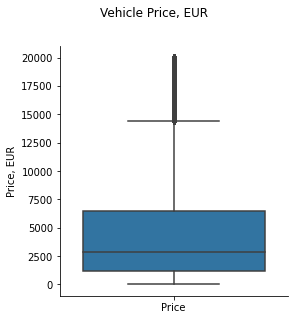

In [9]:
plot = sns.catplot(data=pd.DataFrame(data['Price']), kind='box', height=4, 
                    aspect=1, legend_out=False)
plot.set_axis_labels(y_var='Price, EUR')
plot.set
plot.fig.suptitle('Vehicle Price, EUR', y=1.1);

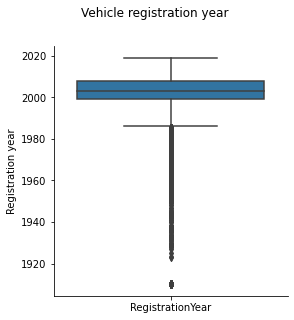

In [10]:
plot = sns.catplot(data=pd.DataFrame(data['RegistrationYear']), kind='box', height=4, 
                    aspect=1, legend_out=False)
plot.set_axis_labels(y_var='Registration year')
plot.set
plot.fig.suptitle('Vehicle registration year', y=1.1);

In [11]:
iqr = data['RegistrationYear'].describe()[6] - data['RegistrationYear'].describe()[4]
cutting_point = data['RegistrationYear'].describe()[4] - 3 * iqr
cutting_point

1972.0

In [12]:
data = data[(data['RegistrationYear'] >= cutting_point) & (data['RegistrationYear'] <= 2016)]

Text(0.5, 1.1, 'Vehicle power')

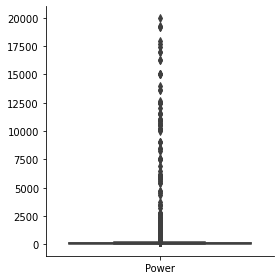

In [13]:
lot = sns.catplot(data=pd.DataFrame(data['Power']), kind='box', height=4, 
                    aspect=1, legend_out=False)
plot.set_axis_labels(y_var='Power')
plot.set
plot.fig.suptitle('Vehicle power', y=1.1)

In [14]:
iqr = data['Power'].describe()[6] - data['Power'].describe()[4]
cutting_point = data['Power'].describe()[6] + 3 * iqr
cutting_point

359.0

In [15]:
data['Power'] = data['Power'].map(lambda x: x if x <= cutting_point else 0)

In [16]:
data.reset_index(drop=True, inplace=True)

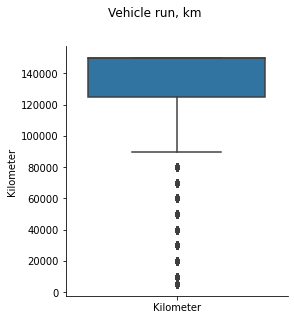

In [17]:
plot = sns.catplot(data=pd.DataFrame(data['Kilometer']), kind='box', height=4, 
                    aspect=1, legend_out=False)
plot.set_axis_labels(y_var='Kilometer')
plot.set
plot.fig.suptitle('Vehicle run, km', y=1.1);

In [18]:
print('Кол-во дубликатов:', data[data.duplicated()]['Price'].count())
print(data.shape[0])
data.drop_duplicates(inplace=True, ignore_index=True)
print(data.shape[0])

Кол-во дубликатов: 25476
328200
302724


In [19]:
data.nunique()

Price                3684
VehicleType             9
RegistrationYear       45
Gearbox                 3
Power                 351
Model                 251
Kilometer              13
RegistrationMonth      13
FuelType                8
Brand                  40
Repaired                3
dtype: int64

In [20]:
def random_digit(row):
    month = row['RegistrationMonth']
    if month == 0:
        return random.randint(1, 12)
    else:
        return month

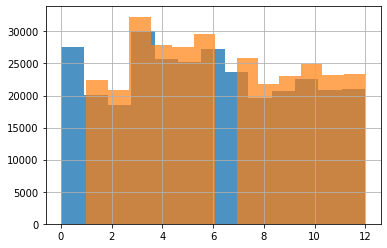

In [21]:
data['RegistrationMonth'].hist(alpha=0.8, bins = 13);
data['RegistrationMonth'] = data.apply(random_digit, axis=1)
data['RegistrationMonth'].hist(alpha=0.7, bins = 13);

### Подготовка признаков к обучению

In [22]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
quantitive = ['Power', 'RegistrationYear', 'Kilometer', 'RegistrationMonth']

```python
# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]
```

```python
# порядковое кодирование (для "деревянных моделей")
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = df.select_dtypes(include=['object']).columns # название датафрейма может отличаться
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])
```

In [23]:
feauters=data.drop('Price', axis=1)
target=data['Price']

In [24]:
features_train, features_test, target_train, target_test = train_test_split(feauters,
target,test_size=0.6,random_state=0)

features_train, features_valid, target_train, target_valid = train_test_split(features_train,
target_train,test_size=0.5,random_state=0)

In [25]:
print(f'тренировочная выборка: {features_train.shape},{target_train.shape}')
print(f'тестовая выборка:      {features_test.shape},{target_test.shape}')
print(f'валидационнаяя выборка:{features_valid.shape},{target_valid.shape}')

тренировочная выборка: (60544, 10),(60544,)
тестовая выборка:      (181635, 10),(181635,)
валидационнаяя выборка:(60545, 10),(60545,)


In [26]:
scaler = StandardScaler()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = data.select_dtypes(include=['object']).columns 
encoder.fit(features_train[cat_columns])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)

In [27]:
# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)

In [28]:
# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_test_ohe.columns) & set(features_valid_ohe.columns)

In [29]:
# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]

In [30]:
warnings.filterwarnings(action='ignore')

features_train_ohe.loc[:, quantitive] = scaler.fit_transform(features_train_ohe.loc[:, quantitive])
features_test_ohe.loc[:, quantitive] = scaler.transform(features_test_ohe.loc[:, quantitive])
features_valid_ohe.loc[:, quantitive] = scaler.transform(features_valid_ohe.loc[:, quantitive])

In [31]:
features_train_ord = features_train.copy()
features_test_ord = features_test.copy()
features_valid_ord = features_valid.copy()

In [32]:
# порядковое кодирование (для "деревянных моделей")
features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])

In [33]:
#numerical_selector = FunctionTransformer(lambda x: x[quantitive], validate=False)
#numerical_preprocessor = Pipeline([("numerical_selector", numerical_selector), ("scaling", scaler)])

In [34]:
#dummy_selector = FunctionTransformer(lambda x: x[categorical], validate=False)
#dummy_preprocessor = Pipeline([("dummy_selector", dummy_selector), ("ohe", encoder)])

In [35]:
#feature_union = FeatureUnion([("numerical_preprocessor", numerical_preprocessor),
                            #("dummy_preprocessor", dummy_preprocessor)])

In [36]:
#pipe = Pipeline([("preprocessing", feature_union), ("modelling", LinearRegression)])

In [37]:
#pipe.fit(features_train ,target_train)

In [38]:
#Preds_test = pipe.predict(features_test)
#Preds_valid= pipe.predict(features_valid)

## Обучение моделей

In [39]:
linear = [LinearRegression(normalize=True), BayesianRidge(normalize=True), LassoLars(normalize=False),
          PassiveAggressiveRegressor(random_state=12345)]
trees = [DecisionTreeRegressor(random_state=12345, max_depth=15)]
gb = [GradientBoostingRegressor(random_state=12345, n_estimators=1200, learning_rate=0.25)]

In [40]:
results = pd.DataFrame({'Regressor' : [], 'CV RMSE score' : [], 'Train RMSE score' : [], 
                        'Learning Time' : [], 'Prediction Time' : []})

In [41]:
def learn_models(models_list, x_train, y_train, y_valid, params={}, model='default', regr_name='', n_jobs=-1):

    for i in models_list:
        regr_gs = GridSearchCV(i, params, cv=5, scoring='neg_root_mean_squared_error')
        if model == 'default':
            regr_gs.fit(x_train,y_train)
        if model == 'catboost':
            regr_gs.fit(x_train,y_train, cat_features=categorical)
        else:
            regr_gs.fit(x_train,y_train)
            
        cv_score = regr_gs.best_score_
        
        regr = regr_gs.best_estimator_
        start_learning = time.time()
        if model == 'default':
            regr.fit(x_train,y_train)
        if model == 'catboost':
            regr.fit(x_train,y_train, cat_features=categorical)
        else:
            regr.fit(x_train,y_train)
        
        end_learning = time.time()
        duration_learning = end_learning - start_learning

        start_prediction = time.time()
        train_rmse_score = np.sqrt(mean_squared_error(y_train, regr.predict(y_valid), squared=False))
        end_prediction = time.time()
        duration_prediction = end_prediction - start_prediction

        
        if regr_name == '':
            name = str(i).split(sep='(')[0]
        else:
            name = regr_name

        globals()['results'] = globals()['results'].append({
            'Regressor' : name, 'CV RMSE score' : round(cv_score, 2), 'Train RMSE score' : round(train_rmse_score, 2), 
            'Learning Time' :  round(duration_learning, 2), 
            'Prediction Time' : round(duration_prediction, 2)}, ignore_index=True)

In [ ]:
learn_models(linear,features_train_ohe, target_train ,target_valid)

In [ ]:
learn_models(trees, features_train_ord, target_train,target_valid )

In [ ]:
learn_models(gb, features_train_ord, target_train,target_valid ,
             regr_name='GradientBoostingRegressor')

In [ ]:
results

# XGBoost

In [ ]:
xgb_regr = xgb.XGBRegressor(learning_rate=0.1, n_estimators=1200)

In [ ]:
learn_models([xgb_regr], features_train_ord, target_train,target_valid, 
             regr_name='XGBRegressor')

In [ ]:
results

# CatBoost

In [ ]:
cat_regr = CatBoostRegressor(iterations=1200, learning_rate=0.25, verbose=False)

In [ ]:
learn_models([cat_regr], features_train_ord, target_train,target_valid , 
             regr_name='CatBoostRegressor (ordinal)')

In [ ]:
learn_models([cat_regr], features_train_ohe, target_train,target_valid , 
             regr_name='CatBoostRegressor (ohe)')

In [ ]:
results

## Анализ моделей

In [ ]:
results.sort_values('Train RMSE score', ascending=True)

## Тестирование лучшей модели

In [ ]:
# гиперпараметры optuna
def objective(trial):
    param = {}
    param['C'] = trial.suggest_discrete_uniform("C", 0.01, 0.1, 0.5,1)
    param['n_iter_no_change']= trial.suggest_int('n_iter_no_change',1,5,7)
    param['max_iter'] = 1000
    param['random_state'] = 0

    regressor = PassiveAggressiveRegressor(**param)

    regressor.fit(features_train_ohe.copy(), target_train.copy())
    loss = np.sqrt(mean_squared_error(target_valid, regressor.predict(features_valid_ohe.copy())))
    return loss

In [ ]:
%%time
study = optuna.create_study(study_name=f'PassiveAggressiveRegressor-seed{0}')
study.optimize(objective, n_trials=1000, n_jobs=-1, timeout=2400)

In [ ]:
print(f' лучшая метрика: \n{study.best_value}\n оптимальные гиперпараметры: {study.best_params}')

## Вывод

лучший результат по точности показала модель PassiveAggressiveRegressor